# Circuit synthesis

**Quantum circuit synthesis** is the process of converting a mathematical description of a quantum transformation - often given as a unitary matrix - into a circuit composed of gates from a fixed gate set.

**Search-based synthesis tools** are categorized by the discrete search for a desired circuit through a space of circuits. These techniques are usually bottom-up, they start with an empty circuit and grow out as they search through the space.

![image.jpg](Fig1_circuit_synthesis_schema.jpg) 
*Fig.1. Hierarchical synthesis or instantiation-based circuit optimization. Both the partitioning strategy and the quality of numerical optimization determine performance and final output quality. Image source [1].*

## 1. QSearch

**QSearch** is a powerful search-based synthesis tool, which phrases the problem of circuit synthesis as a search over circuit structures combined with numerical optimization to instantiate circuit parameters.

1) The algorithm starts by placing single-qubit rotations on all qubits.

2) The circuit is then instantiated by calling a numerical optimization subroutine to solve for the gate's parameters that minimize the distance between the circuit's unitary and the target unitary.

3) After this, fixed building blocks composed of two-qubit gates followed by single-qubit rotations are placed on all pairs of qubits.

This branching pattern forms the circuit tree, where at depth **n** in the tree, all possible circuit structures with **n** two-qubit gates exist.

Each structure is a candidate solution and is evaluated using the same numerical optimization process, and the order of evaluations is determined by A-star search (starting from the most important node).


The code below represents the default transpiler stack in Qiskit, which includes standard optimization techniques and transformations for quantum circuits. The transpiler applies optimizations such as gate decomposition, gate cancellation, and routing to adapt the circuit for execution on the target backend.

In [1]:
from rivet_transpiler import transpile

To create a Bind Circuit we first have to define a litmus circuit.
**Litmus circuit** is a minimal quantum circuit which consists of:

- Parametrized RZ gate on each qubit (each parameter name matches the  index of the virtual qubit - to trace consequent permutations of qubits during layout and routing phases of transpilation).

- Circular CNOT gates (necessary to introduce SWAPs during transpilation to not fully connected topology).

In [2]:
from rivet_transpiler import get_litmus_circuit

QUBITS_COUNT = 3
litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")
litmus_circuit.draw()

┌──────────────┐          ┌───┐ Litmus 
Litmus_0_0: ┤ Rz(Litmus_0) ├──■───────┤ X ├───░────
            ├──────────────┤┌─┴─┐     └─┬─┘   ░    
Litmus_0_1: ┤ Rz(Litmus_1) ├┤ X ├──■────┼─────░────
            ├──────────────┤└───┘┌─┴─┐  │     ░    
Litmus_0_2: ┤ Rz(Litmus_2) ├─────┤ X ├──■─────░────
            └──────────────┘     └───┘        ░

In [3]:
# Bind Circuit Parameters
bound_litmus_circuit = litmus_circuit.copy()

for index, parameter in enumerate(litmus_circuit.parameters):

    bound_litmus_circuit.assign_parameters(
        {parameter: index},
        inplace=True)

To be able execute code below - matplotlib package should be installed:

In [ ]:
# !pip install matplotlib

As a minimal example to run, we select the simplest 5qubit backend:


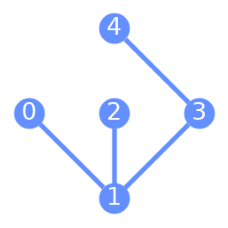

In [4]:
import qiskit
from rivet_transpiler import transpile
from qiskit_ibm_runtime.fake_provider import FakeLimaV2

backend = FakeLimaV2() 

qiskit.visualization.plot_gate_map(backend)

In [5]:
STACKS = ["qiskit",
          "qiskit_qsearch",
          "qiskit_qfactor_qsearch",
          "qiskit_pytket"]

In [6]:
#FAKE_BACKEND = FakeLimaV2()
#backend = qiskit.providers.aer.AerSimulator.from_backend(FAKE_BACKEND)

#backend.options.noise_model = None

Run the circuit on a selected backend and `qiskit_qsearch` stack. Make sure you have installed all stacks: 
- `pip install .[stacks]`
- for Mac OS `pip install ."[stacks]"`

In [7]:
transpiled_circuit = transpile(
    bound_litmus_circuit,
    backend,
    stack="qiskit_qsearch",
    qsearch_block_size=2,
    seed_transpiler=1234)

transpiled_circuit.draw(fold=-1)

Frontier emptied.
Returning best known circuit with 0 layers and cost: 4.999996e-01.
Frontier emptied.
Returning best known circuit with 0 layers and cost: 4.999996e-01.


global phase: 3.1624
                                                                          ┌────────────┐┌────┐    ┌──────────┐   ┌────┐┌────────────┐                                                              ░ 
      q_0 -> 0 ────────────────────────────────────────────────────────■──┤ Rz(3.1823) ├┤ √X ├────┤ Rz(6.28) ├───┤ √X ├┤ Rz(9.4673) ├──────────────────────────────────────────────────────────────░─
               ┌────────────┐  ┌────┐  ┌────────┐┌────┐┌────────────┐┌─┴─┐├────────────┤├────┤┌───┴──────────┴──┐├────┤├────────────┤                                                              ░ 
      q_1 -> 1 ┤ Rz(2.0708) ├──┤ √X ├──┤ Rz(2π) ├┤ √X ├┤ Rz(13.637) ├┤ X ├┤ Rz(1.5708) ├┤ √X ├┤ Rz(-1.4919e-09) ├┤ √X ├┤ Rz(1.5708) ├──■───────────────────────────────────────────────────────────░─
               └───┬───┬────┘┌─┴────┴─┐└────────┘└────┘└────────────┘└───┘└────────────┘└────┘└─────────────────┘└────┘└────────────┘┌─┴─┐┌────────────┐┌────┐┌────────────────┐┌────┐┌──────────┐ ░ 
      q_2 -> 2 ────┤ X ├─────┤ Rz(-2) ├──────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ Rz(1.0516) ├┤ √X ├┤ Rz(-0.0012165) ├┤ √X ├┤ Rz(1.01) ├─░─
                   └───┘     └────────┘                                                                                              └───┘└────────────┘└────┘└────────────────┘└────┘└──────────┘ ░ 
ancilla_0 -> 3 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                     
ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## 2. QFactor + QSearch

This stack includes additional optimization techniques specific to factoring problems, such as techniques for factoring quantum circuits into smaller blocks or sub-circuits. Rivet can apply specialized optimizations aimed at improving performance or reducing errors for factoring-related quantum algorithms.

In [8]:
transpiled_circuit = transpile(
    bound_litmus_circuit,
    backend,
    stack="qiskit_qfactor_qsearch",
    qsearch_block_size=2,
    seed_transpiler=1234)

transpiled_circuit.draw(fold=-1)

Frontier emptied.
Returning best known circuit with 0 layers and cost: 1.582640e-01.
Frontier emptied.
Returning best known circuit with 0 layers and cost: 1.582640e-01.


global phase: 1.8804
                                                                            ┌──────────┐                                    ┌────┐    ┌─────────────┐     ┌────┐    ┌────────────┐                     ┌─────────────┐┌────┐┌─────────────┐┌────┐┌─────────────┐                                                                                                  
      q_0 -> 0 ──────────────────────────────────────────────────────────■──┤ Rz(-π/2) ├────────────────────────────■───────┤ √X ├────┤ Rz(-1.3047) ├─────┤ √X ├────┤ Rz(2.8051) ├──────────────────■──┤ Rz(-2.8773) ├┤ √X ├┤ Rz(-1.4384) ├┤ √X ├┤ Rz(-2.1897) ├──────────────────────────────────────────────────────────────────────────────────────────────────
               ┌────────────┐┌────┐  ┌──────────┐  ┌────┐ ┌──────────┐ ┌─┴─┐└┬────────┬┘┌────┐┌────────────┐┌────┐┌─┴─┐┌────┴────┴───┐└────┬────┬───┘┌────┴────┴───┐└───┬────┬───┘┌──────────────┐┌─┴─┐└┬────────────┤├────┤├─────────────┤├────┤└┬────────────┤     ┌────┐┌────────────┐┌────┐┌────────┐     ┌────────────┐                                      
      q_1 -> 1 ┤ Rz(4.2169) ├┤ √X ├──┤ Rz(3π/2) ├──┤ √X ├─┤ Rz(7π/2) ├─┤ X ├─┤ Rz(-π) ├─┤ √X ├┤ Rz(1.1989) ├┤ √X ├┤ X ├┤ Rz(-1.5496) ├─────┤ √X ├────┤ Rz(-1.5724) ├────┤ √X ├────┤ Rz(0.075334) ├┤ X ├─┤ Rz(1.5708) ├┤ √X ├┤ Rz(-3.1204) ├┤ √X ├─┤ Rz(1.5708) ├──■──┤ √X ├┤ Rz(1.8368) ├┤ √X ├┤ Rz(-π) ├──■──┤ Rz(2.7697) ├──────────────────────────────────────
               ├────────────┤├────┤┌─┴──────────┴─┐├────┤┌┴──────────┴┐└───┘ └────────┘ └────┘└────────────┘└────┘└───┘└─────────────┘     └────┘    └─────────────┘    └────┘    └──────────────┘└───┘ └────────────┘└────┘└─────────────┘└────┘ └────────────┘┌─┴─┐├────┤├────────────┤├────┤├────────┤┌─┴─┐└┬─────────┬─┘┌────┐┌────────────┐┌────┐┌──────────┐
      q_2 -> 2 ┤ Rz(2.8451) ├┤ √X ├┤ Rz(-0.94922) ├┤ √X ├┤ Rz(2.7496) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ √X ├┤ Rz(1.3902) ├┤ √X ├┤ Rz(-π) ├┤ X ├─┤ Rz(π/2) ├──┤ √X ├┤ Rz(9.5882) ├┤ √X ├┤ Rz(5π/2) ├
               └────────────┘└────┘└──────────────┘└────┘└────────────┘                                                                                                                                                                                         └───┘└────┘└────────────┘└────┘└────────┘└───┘ └─────────┘  └────┘└────────────┘└────┘└──────────┘
ancilla_0 -> 3 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                                                                                                                                                                                  
ancilla_1 -> 4 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Conclusions

For circuit optimization, various techniques can be used. Here we presented the results for search-based synthesis tools, namely for QFactor and QSearch. Rivet transpiler is extendable with additional stacks and uses an open architecture.

Rivet transpiler harnesses the full power of the Berkeley Quantum Synthesis Toolkit (BQSKit) [2], which is a powerful and portable quantum compiler framework.

### References
[1] QFactor: A Domain-Specific Optimizer for Quantum Circuit Instantiation –https://arxiv.org/pdf/2306.08152.pdf

[2] https://bqskit.lbl.gov